<a href="https://colab.research.google.com/github/sazio/NMAs/blob/main/Data_Loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis of Stringer Dataset 
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

# to do list

1. custom normalization: dividing by mean value per neuron
1a. downsampling: convolve then downsample by 5
2. training validation split: withhold last 20 percent of time series for testing
3. RNN for each layer: a way to capture the dynamics inside each layer instead of capturing extra dynamics from inter-layer interactions. it will be OK to compare the different RNNs. maintain same neuron count in each layer to reduce potential bias 
4. layer weight regularization: L2 
5. early stopping , dropout?

In [1]:
#%%capture
#!pip install wandb --upgrade --quiet

In [2]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sazio (use `wandb login --relogin` to force relogin)


True

## Loading of Stringer spontaneous data



In [3]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [4]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [5]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [6]:
# functions 

def moving_avg(array, factor = 5):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    zeros_ = np.zeros((array.shape[0], 2))
    array = np.hstack((array, zeros_))

    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor))
    array = np.mean(array, axis = 2)

    return array

## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [7]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [8]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [9]:
# it can be done in one loop ... 
data_ = []
for i in range(0, 9):
    data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1].values)

dataRNN = np.zeros((n_samples*9, dataSet.shape[1]-1))
for i in range(0,9):
    
    # dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]
    ## normalized by layer
    dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]/np.mean(np.asarray(data_)[i,:,:], axis = 0)

## shuffling for training purposes

#np.random.shuffle(dataRNN)

In [10]:
#unshuffled = np.array(data_)

In [11]:
#@title Convolutions code

# convolution moving average

# kernel_length = 50
# averaging_kernel = np.ones(kernel_length) / kernel_length

# dataRNN.shape

# avgd_dataRNN = list()

# for neuron in dataRNN:
#   avgd_dataRNN.append(np.convolve(neuron, averaging_kernel))

# avg_dataRNN = np.array(avgd_dataRNN)

# print(avg_dataRNN.shape)

In [12]:
# @title Z Score Code 


# from scipy.stats import zscore


# neuron = 500

# scaled_all = zscore(avg_dataRNN)
# scaled_per_neuron = zscore(avg_dataRNN[neuron, :])

# scaled_per_layer = list()

# for layer in unshuffled:
#   scaled_per_layer.append(zscore(layer))

# scaled_per_layer = np.array(scaled_per_layer)



# plt.plot(avg_dataRNN[neuron, :])
# plt.plot(avg_dataRNN[2500, :])
# plt.figure()
# plt.plot(dataRNN[neuron, :])
# plt.figure()
# plt.plot(scaled_all[neuron, :])
# plt.plot(scaled_per_neuron)
# plt.figure()
# plt.plot(scaled_per_layer[0,neuron,:])


In [13]:
# custom normalization

normed_dataRNN = list()
for neuron in dataRNN:
    normed_dataRNN.append(neuron)# / neuron.mean())
normed_dataRNN = np.array(normed_dataRNN)

# downsampling and averaging 
#avgd_normed_dataRNN = dataRNN#
avgd_normed_dataRNN = dataRNN #moving_avg(dataRNN, factor=2)

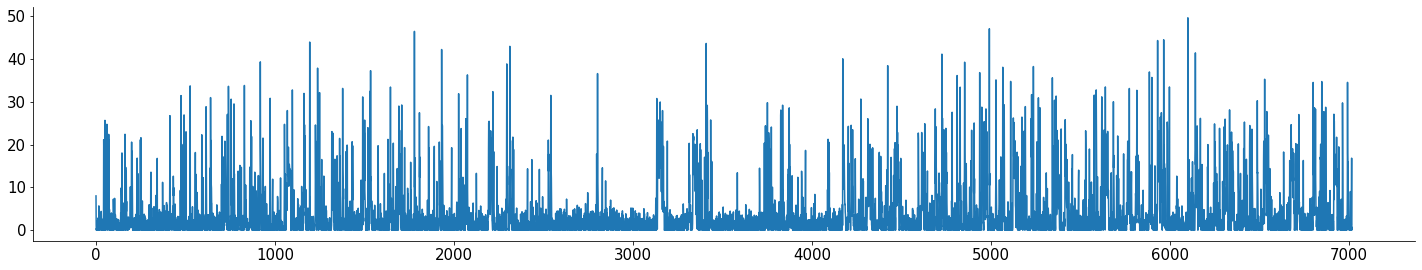

In [14]:
plt.plot(avgd_normed_dataRNN[0,:])

issue: does the individual scaling by layer introduce bias that may artificially increase performance of the network?

## Data Loader 


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.empty_cache()

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

In [18]:
# swapping the axes to maintain consistency with seq2seq notebook in the following code - the network takes all the neurons at a time step as input, not just one neuron

# avgd_normed_dataRNN = np.swapaxes(avgd_normed_dataRNN, 0, 1)
avgd_normed_dataRNN.shape

(10179, 7018)

In [19]:
frac = 4/5

#x1 = torch.from_numpy(dataRNN[:,:int(frac*dataRNN.shape[1])]).to(device).float().unsqueeze(0)
#x2 = torch.from_numpy(dataRNN[:,int(frac*dataRNN.shape[1]):]).to(device).float().unsqueeze(0)
#x1 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)
#x2 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)

n_neurs = 1131
# let's use n_neurs/10 latent components
ncomp = int(n_neurs/10)

x1_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)
x2_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)

x1_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)
x2_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)

NN1 = x1_train.shape[0]
NN2 = x2_train.shape[0]


In [20]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, num_layers = 1, n_comp = 50, dropout= 0,  bidi=True):
        super(Net, self).__init__()

        # play with some of the options in the RNN!
        
        self.rnn = nn.LSTM(NN1, ncomp, num_layers = num_layers, dropout = dropout,
                         bidirectional = bidi)
        """
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        self.rnn = nn.GRU(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        """
        
        self.mlp = nn.Sequential(
                    nn.Linear(ncomp, ncomp*2),
                    nn.Mish(),
                    nn.Linear(ncomp*2, ncomp*2),
                    nn.Mish(),
                    nn.Dropout(0.25),
                    nn.Linear(ncomp*2, ncomp), 
                    nn.Mish())
        
        self.fc = nn.Linear(ncomp, NN2)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        #print(x.shape)
        # h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
        
        y, h_n = self.rnn(x)

        #print(y.shape)
        #print(h_n.shape)
        if self.rnn.bidirectional:
          # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
          # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
            q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
        else:
            q = y
        
        q = self.mlp(q)

        # the softplus function is just like a relu but it's smoothed out so we can't predict 0
        # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
        #z = F.softplus(self.fc(q), 10)
        #print(q.shape)
        z = self.fc(q).permute(2, 0, 1)
        # print(z.shape)
        return z, q

In [21]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam']
        },
    'num_layers': {
        'values': [1]
        },
    'n_comp': {
        'values': [100, 200, 300, 400, 500]#[50, 75, 100, 125, 150]
        },
    
    'dropout': {
          'values': [0.1, 0.2, 0.3, 0.5]
        },
    'weight_decay': {
          'values': [0., 1e-5, 5e-5, 1e-6]
        },
    }

sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'value': 4000}
    })

import math

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'log_uniform',
        'min': -9.9,
        'max': -5.3
    },
})

import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'dropout': {'values': [0.1, 0.2, 0.3, 0.5]},
                'epochs': {'value': 4000},
                'learning_rate': {'distribution': 'log_uniform',
                                  'max': -5.3,
                                  'min': -9.9},
                'n_comp': {'values': [100, 200, 300, 400, 500]},
                'num_layers': {'values': [1]},
                'optimizer': {'values': ['adam']},
                'weight_decay': {'values': [0.0, 1e-05, 5e-05, 1e-06]}}}


In [22]:
sweep_id = wandb.sweep(sweep_config, project="NMAs-Full-Signals")

Create sweep with ID: cbewt4f6
Sweep URL: https://wandb.ai/sazio/NMAs-Full-Signals/sweeps/cbewt4f6


In [23]:
# you can keep re-running this cell if you think the cost might decrease further
cost = nn.MSELoss()

# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370

## Training 

In [24]:
from tqdm import tqdm

In [25]:
def build_optimizer(network, optimizer, learning_rate, weight_decay): 
    optimizer = torch.optim.Adam(network.parameters(),
                               lr=learning_rate, weight_decay=weight_decay)
    return optimizer

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        # loader = build_dataset(config.batch_size)
        # Net(ncomp, NN1, NN2, bidi = True).to(device)
        network = Net(ncomp, NN1, NN2, config.num_layers, config.dropout).to(device)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate, config.weight_decay)

        for epoch in range(config.epochs):
            # avg_loss = train_epoch(network, loader, optimizer)
            network.train()
            # the networkwork outputs the single-neuron prediction and the latents
            z, y = network(x1_train)

            # our cost
            loss = cost(z, x2_train)

            # train the networkwork as usual
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            with torch.no_grad():
                network.eval()
                valid_loss = cost(network(x1_valid)[0], x2_valid)

            if epoch % 50 == 0:
                with torch.no_grad():
                    network.eval()
                    valid_loss = cost(network(x1_valid)[0], x2_valid)
                    
                    print(f' iteration {epoch}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')
            wandb.log({"train_loss": loss.item(), 'valid_loss': valid_loss.item(), "epoch": epoch})

In [26]:
wandb.agent(sweep_id, train, count= 50)

wandb: Agent Starting Run: pldymmld with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00011563659857483612
wandb: 	n_comp: 300
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9297, valid cost 5.0318
 iteration 50, train cost 4.2799, valid cost 4.3479
 iteration 100, train cost 3.4613, valid cost 3.5393
 iteration 150, train cost 3.3112, valid cost 3.3891
 iteration 200, train cost 3.2903, valid cost 3.3662
 iteration 250, train cost 3.2833, valid cost 3.3603
 iteration 300, train cost 3.2793, valid cost 3.3574
 iteration 350, train cost 3.2753, valid cost 3.3545
 iteration 400, train cost 3.2691, valid cost 3.3494
 iteration 450, train cost 3.2578, valid cost 3.3388
 iteration 500, train cost 3.2335, valid cost 3.3141
 iteration 550, train cost 3.1907, valid cost 3.2714
 iteration 600, train cost 3.1484, valid cost 3.2294
 iteration 650, train cost 3.1054, valid cost 3.1839
 iteration 700, train cost 3.0612, valid cost 3.1361
 iteration 750, train cost 3.0267, valid cost 3.0977
 iteration 800, train cost 2.9998, valid cost 3.0672
 iteration 850, train cost 2.9754, valid cost 3.0394
 iteration 900, train cost 2.9503, valid cost 3.0

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.1707
valid_loss,2.28533
epoch,3999
_runtime,1235
_timestamp,1628985590
_step,3999


train_loss,█▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6voyndhc with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.003024210109662325
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9301, valid cost 4.9887
 iteration 50, train cost 3.2790, valid cost 3.3649
 iteration 100, train cost 3.2680, valid cost 3.3546
 iteration 150, train cost 3.2210, valid cost 3.2910
 iteration 200, train cost 3.1661, valid cost 3.2338
 iteration 250, train cost 3.0759, valid cost 3.1510
 iteration 300, train cost 3.0278, valid cost 3.0868
 iteration 350, train cost 2.9463, valid cost 3.0161
 iteration 400, train cost 2.8736, valid cost 2.9498
 iteration 450, train cost 2.8245, valid cost 2.9102
 iteration 500, train cost 2.7774, valid cost 2.8821
 iteration 550, train cost 2.7491, valid cost 2.8641
 iteration 600, train cost 2.7539, valid cost 2.8583
 iteration 650, train cost 2.7084, valid cost 2.8712
 iteration 700, train cost 2.6402, valid cost 2.7868
 iteration 750, train cost 2.5990, valid cost 2.7622
 iteration 800, train cost 2.6171, valid cost 2.7663
 iteration 850, train cost 2.5413, valid cost 2.7195
 iteration 900, train cost 2.5049, valid cost 2.6

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.9582
valid_loss,2.34771
epoch,3999
_runtime,1235
_timestamp,1628986829
_step,3999


train_loss,██▇▇▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁
valid_loss,██▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▁▁▁▁▁▂▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1lcugb4t with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 5.406403573394386e-05
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9332, valid cost 5.0362
 iteration 50, train cost 4.8146, valid cost 4.9101
 iteration 100, train cost 4.0673, valid cost 4.1402
 iteration 150, train cost 3.5902, valid cost 3.6634
 iteration 200, train cost 3.4047, valid cost 3.4759
 iteration 250, train cost 3.3387, valid cost 3.4073
 iteration 300, train cost 3.3141, valid cost 3.3811
 iteration 350, train cost 3.3015, valid cost 3.3704
 iteration 400, train cost 3.2952, valid cost 3.3655
 iteration 450, train cost 3.2914, valid cost 3.3630
 iteration 500, train cost 3.2884, valid cost 3.3614
 iteration 550, train cost 3.2860, valid cost 3.3603
 iteration 600, train cost 3.2843, valid cost 3.3596
 iteration 650, train cost 3.2825, valid cost 3.3588
 iteration 700, train cost 3.2807, valid cost 3.3580
 iteration 750, train cost 3.2794, valid cost 3.3572
 iteration 800, train cost 3.2780, valid cost 3.3564
 iteration 850, train cost 3.2764, valid cost 3.3553
 iteration 900, train cost 3.2745, valid cost 3.3

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.49588
valid_loss,2.58365
epoch,3999
_runtime,1237
_timestamp,1628988070
_step,3999


train_loss,█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: u6lfj0hn with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 8.268778791940804e-05
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9277, valid cost 5.0296
 iteration 50, train cost 4.5277, valid cost 4.6036
 iteration 100, train cost 3.7113, valid cost 3.7823
 iteration 150, train cost 3.3935, valid cost 3.4657
 iteration 200, train cost 3.3151, valid cost 3.3867
 iteration 250, train cost 3.2972, valid cost 3.3690
 iteration 300, train cost 3.2902, valid cost 3.3634
 iteration 350, train cost 3.2852, valid cost 3.3605
 iteration 400, train cost 3.2817, valid cost 3.3585
 iteration 450, train cost 3.2786, valid cost 3.3566
 iteration 500, train cost 3.2752, valid cost 3.3539
 iteration 550, train cost 3.2706, valid cost 3.3495
 iteration 600, train cost 3.2638, valid cost 3.3424
 iteration 650, train cost 3.2543, valid cost 3.3314
 iteration 700, train cost 3.2401, valid cost 3.3143
 iteration 750, train cost 3.2203, valid cost 3.2900
 iteration 800, train cost 3.1961, valid cost 3.2613
 iteration 850, train cost 3.1693, valid cost 3.2303
 iteration 900, train cost 3.1393, valid cost 3.1

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.29541
valid_loss,2.4149
epoch,3999
_runtime,1232
_timestamp,1628989306
_step,3999


train_loss,█▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: oeu68pls with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0011022032206845556
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9286, valid cost 5.0178
 iteration 50, train cost 3.2854, valid cost 3.3659
 iteration 100, train cost 3.2693, valid cost 3.3540
 iteration 150, train cost 3.1595, valid cost 3.2373
 iteration 200, train cost 3.0332, valid cost 3.1025
 iteration 250, train cost 2.9437, valid cost 3.0125
 iteration 300, train cost 2.8874, valid cost 2.9678
 iteration 350, train cost 2.8094, valid cost 2.8905
 iteration 400, train cost 2.8039, valid cost 2.8310
 iteration 450, train cost 2.6714, valid cost 2.7601
 iteration 500, train cost 2.6057, valid cost 2.6960
 iteration 550, train cost 2.5524, valid cost 2.6452
 iteration 600, train cost 2.5182, valid cost 2.6100
 iteration 650, train cost 2.4801, valid cost 2.5752
 iteration 700, train cost 2.4428, valid cost 2.5430
 iteration 750, train cost 2.4057, valid cost 2.5093
 iteration 800, train cost 2.3718, valid cost 2.4792
 iteration 850, train cost 2.3390, valid cost 2.4508
 iteration 900, train cost 2.3137, valid cost 2.4

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.78558
valid_loss,1.99505
epoch,3999
_runtime,1238
_timestamp,1628990548
_step,3999


train_loss,██▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
valid_loss,██▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hemibm0h with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0001435728411819347
wandb: 	n_comp: 500
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9341, valid cost 5.0358
 iteration 50, train cost 4.1297, valid cost 4.1962
 iteration 100, train cost 3.4081, valid cost 3.4835
 iteration 150, train cost 3.3006, valid cost 3.3763
 iteration 200, train cost 3.2854, valid cost 3.3622
 iteration 250, train cost 3.2802, valid cost 3.3583
 iteration 300, train cost 3.2759, valid cost 3.3556
 iteration 350, train cost 3.2706, valid cost 3.3519
 iteration 400, train cost 3.2622, valid cost 3.3437
 iteration 450, train cost 3.2442, valid cost 3.3252
 iteration 500, train cost 3.2065, valid cost 3.2845
 iteration 550, train cost 3.1430, valid cost 3.2171
 iteration 600, train cost 3.0867, valid cost 3.1558
 iteration 650, train cost 3.0431, valid cost 3.1066
 iteration 700, train cost 3.0024, valid cost 3.0633
 iteration 750, train cost 2.9656, valid cost 3.0277
 iteration 800, train cost 2.9368, valid cost 3.0019
 iteration 850, train cost 2.9092, valid cost 2.9778
 iteration 900, train cost 2.8780, valid cost 2.9

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.15543
valid_loss,2.25247
epoch,3999
_runtime,1239
_timestamp,1628991792
_step,3999


train_loss,█▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: j9vsj2x7 with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0001383658338557298
wandb: 	n_comp: 400
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9297, valid cost 5.0309
 iteration 50, train cost 4.0539, valid cost 4.0999
 iteration 100, train cost 3.3850, valid cost 3.4559
 iteration 150, train cost 3.3025, valid cost 3.3744
 iteration 200, train cost 3.2882, valid cost 3.3624
 iteration 250, train cost 3.2826, valid cost 3.3590
 iteration 300, train cost 3.2780, valid cost 3.3565
 iteration 350, train cost 3.2727, valid cost 3.3524
 iteration 400, train cost 3.2628, valid cost 3.3430
 iteration 450, train cost 3.2405, valid cost 3.3193
 iteration 500, train cost 3.1894, valid cost 3.2628
 iteration 550, train cost 3.1305, valid cost 3.1993
 iteration 600, train cost 3.0967, valid cost 3.1641
 iteration 650, train cost 3.0761, valid cost 3.1417
 iteration 700, train cost 3.0507, valid cost 3.1151
 iteration 750, train cost 3.0130, valid cost 3.0764
 iteration 800, train cost 2.9791, valid cost 3.0410
 iteration 850, train cost 2.9508, valid cost 3.0116
 iteration 900, train cost 2.9224, valid cost 2.9

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.13089
valid_loss,2.28127
epoch,3999
_runtime,1239
_timestamp,1628993035
_step,3999


train_loss,█▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 33cd12lv with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00029884782179273676
wandb: 	n_comp: 400
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9274, valid cost 5.0265
 iteration 50, train cost 3.4326, valid cost 3.4909
 iteration 100, train cost 3.2882, valid cost 3.3623
 iteration 150, train cost 3.2795, valid cost 3.3584
 iteration 200, train cost 3.2736, valid cost 3.3543
 iteration 250, train cost 3.2534, valid cost 3.3320
 iteration 300, train cost 3.1836, valid cost 3.2490
 iteration 350, train cost 3.1055, valid cost 3.1662
 iteration 400, train cost 3.0600, valid cost 3.1232
 iteration 450, train cost 3.0033, valid cost 3.0709
 iteration 500, train cost 2.9508, valid cost 3.0181
 iteration 550, train cost 2.8971, valid cost 2.9628
 iteration 600, train cost 2.8509, valid cost 2.9179
 iteration 650, train cost 2.8029, valid cost 2.8735
 iteration 700, train cost 2.7565, valid cost 2.8329
 iteration 750, train cost 2.7151, valid cost 2.7970
 iteration 800, train cost 2.6753, valid cost 2.7592
 iteration 850, train cost 2.6367, valid cost 2.7229
 iteration 900, train cost 2.6001, valid cost 2.6

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.9558
valid_loss,2.12468
epoch,3999
_runtime,1240
_timestamp,1628994280
_step,3999


train_loss,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 97hv4m5o with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0030161874561139973
wandb: 	n_comp: 500
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9377, valid cost 5.0067
 iteration 50, train cost 3.2799, valid cost 3.3652
 iteration 100, train cost 3.2728, valid cost 3.3589
 iteration 150, train cost 3.2073, valid cost 3.2785
 iteration 200, train cost 3.1180, valid cost 3.1917
 iteration 250, train cost 3.0444, valid cost 3.1191
 iteration 300, train cost 3.0111, valid cost 3.0890
 iteration 350, train cost 2.9504, valid cost 3.0330
 iteration 400, train cost 2.8846, valid cost 2.9735
 iteration 450, train cost 2.8291, valid cost 2.9346
 iteration 500, train cost 2.7793, valid cost 2.9046
 iteration 550, train cost 2.7483, valid cost 2.8836
 iteration 600, train cost 2.7016, valid cost 2.8644
 iteration 650, train cost 2.6668, valid cost 2.8479
 iteration 700, train cost 2.6301, valid cost 2.8259
 iteration 750, train cost 2.5918, valid cost 2.8021
 iteration 800, train cost 2.5582, valid cost 2.7823
 iteration 850, train cost 2.5279, valid cost 2.7677
 iteration 900, train cost 2.5036, valid cost 2.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.96907
valid_loss,2.45602
epoch,3999
_runtime,1239
_timestamp,1628995523
_step,3999


train_loss,██▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▆▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 94lp0nyl with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0004786530328312789
wandb: 	n_comp: 500
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9285, valid cost 5.0251
 iteration 50, train cost 3.3266, valid cost 3.4038
 iteration 100, train cost 3.2819, valid cost 3.3613
 iteration 150, train cost 3.2753, valid cost 3.3569
 iteration 200, train cost 3.2677, valid cost 3.3492
 iteration 250, train cost 3.2272, valid cost 3.2982
 iteration 300, train cost 3.1476, valid cost 3.2080
 iteration 350, train cost 3.0578, valid cost 3.1219
 iteration 400, train cost 2.9976, valid cost 3.0653
 iteration 450, train cost 2.9394, valid cost 3.0143
 iteration 500, train cost 2.8895, valid cost 2.9709
 iteration 550, train cost 2.8423, valid cost 2.9312
 iteration 600, train cost 2.8002, valid cost 2.8940
 iteration 650, train cost 2.7573, valid cost 2.8553
 iteration 700, train cost 2.7125, valid cost 2.8142
 iteration 750, train cost 2.6660, valid cost 2.7740
 iteration 800, train cost 2.6229, valid cost 2.7366
 iteration 850, train cost 2.5840, valid cost 2.7070
 iteration 900, train cost 2.5507, valid cost 2.6

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.87021
valid_loss,2.12637
epoch,3999
_runtime,1232
_timestamp,1628996759
_step,3999


train_loss,█▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vc9sue1g with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0018102133932468016
wandb: 	n_comp: 300
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9371, valid cost 5.0175
 iteration 50, train cost 3.2809, valid cost 3.3655
 iteration 100, train cost 3.2689, valid cost 3.3533
 iteration 150, train cost 3.1819, valid cost 3.2518
 iteration 200, train cost 3.0588, valid cost 3.1273
 iteration 250, train cost 2.9535, valid cost 3.0243
 iteration 300, train cost 2.8660, valid cost 2.9462
 iteration 350, train cost 2.8075, valid cost 2.8943
 iteration 400, train cost 2.7497, valid cost 2.8419
 iteration 450, train cost 2.6878, valid cost 2.7912
 iteration 500, train cost 2.6524, valid cost 2.7695
 iteration 550, train cost 2.5856, valid cost 2.7219
 iteration 600, train cost 2.5445, valid cost 2.6947
 iteration 650, train cost 2.5054, valid cost 2.6675
 iteration 700, train cost 2.4616, valid cost 2.6325
 iteration 750, train cost 2.4296, valid cost 2.6041
 iteration 800, train cost 2.3881, valid cost 2.5760
 iteration 850, train cost 2.3599, valid cost 2.5788
 iteration 900, train cost 2.3341, valid cost 2.5

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.79705
valid_loss,2.15498
epoch,3999
_runtime,1240
_timestamp,1628998004
_step,3999


train_loss,██▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rzmaigbd with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0004885494600036471
wandb: 	n_comp: 200
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9295, valid cost 5.0272
 iteration 50, train cost 3.3190, valid cost 3.3949
 iteration 100, train cost 3.2820, valid cost 3.3611
 iteration 150, train cost 3.2734, valid cost 3.3552
 iteration 200, train cost 3.2540, valid cost 3.3357
 iteration 250, train cost 3.1578, valid cost 3.2288
 iteration 300, train cost 3.0480, valid cost 3.1131
 iteration 350, train cost 2.9689, valid cost 3.0324
 iteration 400, train cost 2.9084, valid cost 2.9758
 iteration 450, train cost 2.8520, valid cost 2.9260
 iteration 500, train cost 2.7937, valid cost 2.8724
 iteration 550, train cost 2.7288, valid cost 2.8114
 iteration 600, train cost 2.6701, valid cost 2.7587
 iteration 650, train cost 2.6228, valid cost 2.7155
 iteration 700, train cost 2.5817, valid cost 2.6774
 iteration 750, train cost 2.5405, valid cost 2.6385
 iteration 800, train cost 2.5003, valid cost 2.6004
 iteration 850, train cost 2.4629, valid cost 2.5648
 iteration 900, train cost 2.4314, valid cost 2.5

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.85334
valid_loss,2.0425
epoch,3999
_runtime,1240
_timestamp,1628999248
_step,3999


train_loss,█▇▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: yrt4fksh with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.004748567238598436
wandb: 	n_comp: 300
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9341, valid cost 4.9830
 iteration 50, train cost 3.2726, valid cost 3.3573
 iteration 100, train cost 3.2181, valid cost 3.2824
 iteration 150, train cost 3.1437, valid cost 3.2015
 iteration 200, train cost 3.0088, valid cost 3.0717
 iteration 250, train cost 2.9416, valid cost 3.0122
 iteration 300, train cost 2.8865, valid cost 2.9657
 iteration 350, train cost 2.8394, valid cost 2.9303
 iteration 400, train cost 2.8043, valid cost 2.9009
 iteration 450, train cost 2.7442, valid cost 2.8619
 iteration 500, train cost 2.6908, valid cost 2.8193
 iteration 550, train cost 2.6297, valid cost 2.7747
 iteration 600, train cost 2.6345, valid cost 2.7683
 iteration 650, train cost 2.5506, valid cost 2.7126
 iteration 700, train cost 2.5742, valid cost 2.7255
 iteration 750, train cost 2.4991, valid cost 2.6750
 iteration 800, train cost 2.4605, valid cost 2.6523
 iteration 850, train cost 2.4271, valid cost 2.6301
 iteration 900, train cost 2.3880, valid cost 2.5

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.9064
valid_loss,2.08598
epoch,3999
_runtime,1240
_timestamp,1629000492
_step,3999


train_loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
valid_loss,█▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: w2p5b5pn with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00013162890250026257
wandb: 	n_comp: 200
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9283, valid cost 5.0301
 iteration 50, train cost 4.0825, valid cost 4.1357
 iteration 100, train cost 3.3839, valid cost 3.4459
 iteration 150, train cost 3.3011, valid cost 3.3682
 iteration 200, train cost 3.2889, valid cost 3.3607
 iteration 250, train cost 3.2830, valid cost 3.3583
 iteration 300, train cost 3.2786, valid cost 3.3564
 iteration 350, train cost 3.2739, valid cost 3.3536
 iteration 400, train cost 3.2674, valid cost 3.3475
 iteration 450, train cost 3.2528, valid cost 3.3329
 iteration 500, train cost 3.2207, valid cost 3.2986
 iteration 550, train cost 3.1654, valid cost 3.2398
 iteration 600, train cost 3.1046, valid cost 3.1752
 iteration 650, train cost 3.0526, valid cost 3.1166
 iteration 700, train cost 3.0094, valid cost 3.0695
 iteration 750, train cost 2.9739, valid cost 3.0314
 iteration 800, train cost 2.9448, valid cost 3.0023
 iteration 850, train cost 2.9193, valid cost 2.9782
 iteration 900, train cost 2.8928, valid cost 2.9

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.13904
valid_loss,2.23269
epoch,3999
_runtime,1238
_timestamp,1629001735
_step,3999


train_loss,█▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 25fkhh96 with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0001447441918317269
wandb: 	n_comp: 200
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9302, valid cost 5.0316
 iteration 50, train cost 3.9813, valid cost 4.0252
 iteration 100, train cost 3.3611, valid cost 3.4273
 iteration 150, train cost 3.2962, valid cost 3.3674
 iteration 200, train cost 3.2871, valid cost 3.3618
 iteration 250, train cost 3.2832, valid cost 3.3600
 iteration 300, train cost 3.2803, valid cost 3.3584
 iteration 350, train cost 3.2772, valid cost 3.3568
 iteration 400, train cost 3.2740, valid cost 3.3546
 iteration 450, train cost 3.2691, valid cost 3.3495
 iteration 500, train cost 3.2574, valid cost 3.3350
 iteration 550, train cost 3.2319, valid cost 3.3037
 iteration 600, train cost 3.1982, valid cost 3.2628
 iteration 650, train cost 3.1547, valid cost 3.2141
 iteration 700, train cost 3.0981, valid cost 3.1533
 iteration 750, train cost 3.0537, valid cost 3.1073
 iteration 800, train cost 3.0161, valid cost 3.0692
 iteration 850, train cost 2.9853, valid cost 3.0376
 iteration 900, train cost 2.9607, valid cost 3.0

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.16185
valid_loss,2.30324
epoch,3999
_runtime,1239
_timestamp,1629002979
_step,3999


train_loss,█▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8m1r06l1 with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0024829470859160786
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9345, valid cost 5.0062
 iteration 50, train cost 3.2754, valid cost 3.3612
 iteration 100, train cost 3.2332, valid cost 3.3121
 iteration 150, train cost 3.0512, valid cost 3.1197
 iteration 200, train cost 2.9579, valid cost 3.0318
 iteration 250, train cost 2.8873, valid cost 2.9619
 iteration 300, train cost 2.8148, valid cost 2.8944
 iteration 350, train cost 2.7433, valid cost 2.8437
 iteration 400, train cost 2.6678, valid cost 2.7628
 iteration 450, train cost 2.6021, valid cost 2.7031
 iteration 500, train cost 2.5470, valid cost 2.6554
 iteration 550, train cost 2.4982, valid cost 2.6302
 iteration 600, train cost 2.4417, valid cost 2.5755
 iteration 650, train cost 2.3971, valid cost 2.5478
 iteration 700, train cost 2.3574, valid cost 2.5136
 iteration 750, train cost 2.3895, valid cost 2.5440
 iteration 800, train cost 2.2907, valid cost 2.4595
 iteration 850, train cost 2.2524, valid cost 2.4626
 iteration 900, train cost 2.2266, valid cost 2.4

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.74652
valid_loss,2.0094
epoch,3999
_runtime,1239
_timestamp,1629004222
_step,3999


train_loss,█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 70fh2n0j with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 5.330792759715102e-05
wandb: 	n_comp: 300
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9319, valid cost 5.0346
 iteration 50, train cost 4.8275, valid cost 4.9243
 iteration 100, train cost 4.1202, valid cost 4.1852
 iteration 150, train cost 3.6205, valid cost 3.6784
 iteration 200, train cost 3.4153, valid cost 3.4738
 iteration 250, train cost 3.3398, valid cost 3.4015
 iteration 300, train cost 3.3101, valid cost 3.3763
 iteration 350, train cost 3.2979, valid cost 3.3670
 iteration 400, train cost 3.2913, valid cost 3.3632
 iteration 450, train cost 3.2877, valid cost 3.3612
 iteration 500, train cost 3.2848, valid cost 3.3600
 iteration 550, train cost 3.2828, valid cost 3.3591
 iteration 600, train cost 3.2808, valid cost 3.3583
 iteration 650, train cost 3.2791, valid cost 3.3573
 iteration 700, train cost 3.2773, valid cost 3.3564
 iteration 750, train cost 3.2754, valid cost 3.3551
 iteration 800, train cost 3.2731, valid cost 3.3533
 iteration 850, train cost 3.2703, valid cost 3.3511
 iteration 900, train cost 3.2672, valid cost 3.3

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.46529
valid_loss,2.54629
epoch,3999
_runtime,1234
_timestamp,1629005460
_step,3999


train_loss,█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jpy4ug1w with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0012831869276291401
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9264, valid cost 5.0113
 iteration 50, train cost 3.2841, valid cost 3.3662
 iteration 100, train cost 3.2682, valid cost 3.3521
 iteration 150, train cost 3.1472, valid cost 3.2217
 iteration 200, train cost 3.0419, valid cost 3.1035
 iteration 250, train cost 2.9481, valid cost 3.0179
 iteration 300, train cost 2.8840, valid cost 2.9536
 iteration 350, train cost 2.8100, valid cost 2.8886
 iteration 400, train cost 2.7462, valid cost 2.8269
 iteration 450, train cost 2.6725, valid cost 2.7598
 iteration 500, train cost 2.6150, valid cost 2.7046
 iteration 550, train cost 2.5653, valid cost 2.6586
 iteration 600, train cost 2.5153, valid cost 2.6117
 iteration 650, train cost 2.4711, valid cost 2.5735
 iteration 700, train cost 2.4352, valid cost 2.5313
 iteration 750, train cost 2.3910, valid cost 2.4967
 iteration 800, train cost 2.3559, valid cost 2.4653
 iteration 850, train cost 2.3294, valid cost 2.4391
 iteration 900, train cost 2.3123, valid cost 2.4

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.79279
valid_loss,2.02018
epoch,3999
_runtime,1240
_timestamp,1629006704
_step,3999


train_loss,██▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▆▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hfqdohd1 with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0038515633187785336
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9206, valid cost 4.9710
 iteration 50, train cost 3.2738, valid cost 3.3648
 iteration 100, train cost 3.2847, valid cost 3.3696
 iteration 150, train cost 3.1907, valid cost 3.2534
 iteration 200, train cost 3.0990, valid cost 3.1615
 iteration 250, train cost 3.0379, valid cost 3.1009
 iteration 300, train cost 3.0120, valid cost 3.0702
 iteration 350, train cost 2.9403, valid cost 3.0497
 iteration 400, train cost 2.8781, valid cost 2.9620
 iteration 450, train cost 2.8418, valid cost 2.9349
 iteration 500, train cost 2.8067, valid cost 2.9140
 iteration 550, train cost 2.7638, valid cost 2.8830
 iteration 600, train cost 2.7287, valid cost 2.8582
 iteration 650, train cost 2.6909, valid cost 2.8671
 iteration 700, train cost 2.6792, valid cost 2.9115
 iteration 750, train cost 2.7199, valid cost 2.8441
 iteration 800, train cost 2.6767, valid cost 2.8105
 iteration 850, train cost 2.6396, valid cost 2.7997
 iteration 900, train cost 2.5799, valid cost 2.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.12301
valid_loss,2.39977
epoch,3999
_runtime,1239
_timestamp,1629007947
_step,3999


train_loss,██▇▆▆▅▅▅▄▄▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁
valid_loss,█▇▆▆▅▅▄▄▄▄▄▄▃▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gbnx4k3e with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0005600925048744197
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9324, valid cost 5.0295
 iteration 50, train cost 3.3072, valid cost 3.3823
 iteration 100, train cost 3.2787, valid cost 3.3595
 iteration 150, train cost 3.2692, valid cost 3.3510
 iteration 200, train cost 3.2035, valid cost 3.2774
 iteration 250, train cost 3.0779, valid cost 3.1446
 iteration 300, train cost 3.0045, valid cost 3.0685
 iteration 350, train cost 2.9414, valid cost 3.0055
 iteration 400, train cost 2.8736, valid cost 2.9437
 iteration 450, train cost 2.7945, valid cost 2.8743
 iteration 500, train cost 2.7234, valid cost 2.8098
 iteration 550, train cost 2.6607, valid cost 2.7535
 iteration 600, train cost 2.6058, valid cost 2.7018
 iteration 650, train cost 2.5603, valid cost 2.6583
 iteration 700, train cost 2.5178, valid cost 2.6185
 iteration 750, train cost 2.4784, valid cost 2.5800
 iteration 800, train cost 2.4422, valid cost 2.5451
 iteration 850, train cost 2.4111, valid cost 2.5140
 iteration 900, train cost 2.3809, valid cost 2.4

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.81246
valid_loss,1.99584
epoch,3999
_runtime,1240
_timestamp,1629009192
_step,3999


train_loss,█▇▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vhuq027w with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0006070141369881178
wandb: 	n_comp: 200
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9299, valid cost 5.0255
 iteration 50, train cost 3.3038, valid cost 3.3811
 iteration 100, train cost 3.2802, valid cost 3.3614
 iteration 150, train cost 3.2733, valid cost 3.3565
 iteration 200, train cost 3.2540, valid cost 3.3334
 iteration 250, train cost 3.1917, valid cost 3.2577
 iteration 300, train cost 3.1428, valid cost 3.2039
 iteration 350, train cost 3.0448, valid cost 3.1142
 iteration 400, train cost 2.9794, valid cost 3.0474
 iteration 450, train cost 2.9391, valid cost 3.0090
 iteration 500, train cost 2.9026, valid cost 2.9808
 iteration 550, train cost 2.8641, valid cost 2.9490
 iteration 600, train cost 2.8235, valid cost 2.9103
 iteration 650, train cost 2.7727, valid cost 2.8647
 iteration 700, train cost 2.7291, valid cost 2.8259
 iteration 750, train cost 2.6893, valid cost 2.7928
 iteration 800, train cost 2.6534, valid cost 2.7622
 iteration 850, train cost 2.6168, valid cost 2.7313
 iteration 900, train cost 2.5838, valid cost 2.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.84142
valid_loss,2.11708
epoch,3999
_runtime,1238
_timestamp,1629010434
_step,3999


train_loss,█▇▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cs2dpwoc with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0001513073212798232
wandb: 	n_comp: 200
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9339, valid cost 5.0356
 iteration 50, train cost 4.0321, valid cost 4.0769
 iteration 100, train cost 3.3621, valid cost 3.4312
 iteration 150, train cost 3.2945, valid cost 3.3678
 iteration 200, train cost 3.2839, valid cost 3.3594
 iteration 250, train cost 3.2780, valid cost 3.3554
 iteration 300, train cost 3.2709, valid cost 3.3497
 iteration 350, train cost 3.2597, valid cost 3.3385
 iteration 400, train cost 3.2374, valid cost 3.3136
 iteration 450, train cost 3.1953, valid cost 3.2672
 iteration 500, train cost 3.1432, valid cost 3.2102
 iteration 550, train cost 3.0941, valid cost 3.1571
 iteration 600, train cost 3.0533, valid cost 3.1144
 iteration 650, train cost 3.0122, valid cost 3.0727
 iteration 700, train cost 2.9695, valid cost 3.0281
 iteration 750, train cost 2.9261, valid cost 2.9839
 iteration 800, train cost 2.8884, valid cost 2.9464
 iteration 850, train cost 2.8561, valid cost 2.9158
 iteration 900, train cost 2.8260, valid cost 2.8

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.11524
valid_loss,2.22567
epoch,3999
_runtime,1240
_timestamp,1629011679
_step,3999


train_loss,█▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: v7spqkvp with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0034307820630174388
wandb: 	n_comp: 500
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9340, valid cost 4.9949
 iteration 50, train cost 3.2704, valid cost 3.3563
 iteration 100, train cost 3.1329, valid cost 3.2025
 iteration 150, train cost 3.0220, valid cost 3.0809
 iteration 200, train cost 2.9226, valid cost 2.9869
 iteration 250, train cost 2.8255, valid cost 2.9040
 iteration 300, train cost 2.7461, valid cost 2.8405
 iteration 350, train cost 2.6916, valid cost 2.7877
 iteration 400, train cost 2.7260, valid cost 2.8223
 iteration 450, train cost 2.5862, valid cost 2.7149
 iteration 500, train cost 2.5303, valid cost 2.6789
 iteration 550, train cost 2.4855, valid cost 2.6525
 iteration 600, train cost 2.4567, valid cost 2.6162
 iteration 650, train cost 2.4237, valid cost 2.5980
 iteration 700, train cost 2.3710, valid cost 2.5548
 iteration 750, train cost 2.3353, valid cost 2.5275
 iteration 800, train cost 2.3089, valid cost 2.5041
 iteration 850, train cost 2.2823, valid cost 2.4820
 iteration 900, train cost 2.4574, valid cost 2.6

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.86148
valid_loss,2.01454
epoch,3999
_runtime,1234
_timestamp,1629012917
_step,3999


train_loss,█▇▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▃▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mcikhqcv with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00013505605458436637
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9290, valid cost 5.0299
 iteration 50, train cost 4.0384, valid cost 4.0938
 iteration 100, train cost 3.3654, valid cost 3.4382
 iteration 150, train cost 3.2979, valid cost 3.3700
 iteration 200, train cost 3.2887, valid cost 3.3632
 iteration 250, train cost 3.2841, valid cost 3.3605
 iteration 300, train cost 3.2800, valid cost 3.3586
 iteration 350, train cost 3.2767, valid cost 3.3568
 iteration 400, train cost 3.2722, valid cost 3.3536
 iteration 450, train cost 3.2628, valid cost 3.3454
 iteration 500, train cost 3.2385, valid cost 3.3218
 iteration 550, train cost 3.1874, valid cost 3.2711
 iteration 600, train cost 3.1319, valid cost 3.2147
 iteration 650, train cost 3.0847, valid cost 3.1627
 iteration 700, train cost 3.0452, valid cost 3.1173
 iteration 750, train cost 3.0075, valid cost 3.0740
 iteration 800, train cost 2.9718, valid cost 3.0342
 iteration 850, train cost 2.9392, valid cost 3.0011
 iteration 900, train cost 2.9084, valid cost 2.9

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.10752
valid_loss,2.25129
epoch,3999
_runtime,1240
_timestamp,1629014161
_step,3999


train_loss,█▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: q4qp0v3j with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.001028257630735163
wandb: 	n_comp: 400
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9279, valid cost 5.0194
 iteration 50, train cost 3.2872, valid cost 3.3667
 iteration 100, train cost 3.2752, valid cost 3.3597
 iteration 150, train cost 3.2628, valid cost 3.3458
 iteration 200, train cost 3.1797, valid cost 3.2440
 iteration 250, train cost 3.0556, valid cost 3.1185
 iteration 300, train cost 2.9654, valid cost 3.0249
 iteration 350, train cost 2.9209, valid cost 2.9874
 iteration 400, train cost 2.8761, valid cost 2.9534
 iteration 450, train cost 2.8301, valid cost 2.9132
 iteration 500, train cost 2.7853, valid cost 2.8623
 iteration 550, train cost 2.7233, valid cost 2.8229
 iteration 600, train cost 2.6816, valid cost 2.7945
 iteration 650, train cost 2.6463, valid cost 2.7641
 iteration 700, train cost 2.6001, valid cost 2.7292
 iteration 750, train cost 2.5567, valid cost 2.6941
 iteration 800, train cost 2.5210, valid cost 2.6642
 iteration 850, train cost 2.4861, valid cost 2.6330
 iteration 900, train cost 2.4535, valid cost 2.6

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.76542
valid_loss,2.037
epoch,3999
_runtime,1240
_timestamp,1629015406
_step,3999


train_loss,██▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: oj7n4aho with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00028886963348329254
wandb: 	n_comp: 300
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9290, valid cost 5.0292
 iteration 50, train cost 3.4975, valid cost 3.5600
 iteration 100, train cost 3.2929, valid cost 3.3679
 iteration 150, train cost 3.2832, valid cost 3.3612
 iteration 200, train cost 3.2777, valid cost 3.3582
 iteration 250, train cost 3.2738, valid cost 3.3552
 iteration 300, train cost 3.2660, valid cost 3.3476
 iteration 350, train cost 3.2387, valid cost 3.3148
 iteration 400, train cost 3.1894, valid cost 3.2559
 iteration 450, train cost 3.1234, valid cost 3.1827
 iteration 500, train cost 3.0632, valid cost 3.1259
 iteration 550, train cost 3.0057, valid cost 3.0702
 iteration 600, train cost 2.9305, valid cost 2.9934
 iteration 650, train cost 2.8656, valid cost 2.9302
 iteration 700, train cost 2.8160, valid cost 2.8869
 iteration 750, train cost 2.7676, valid cost 2.8465
 iteration 800, train cost 2.7227, valid cost 2.8065
 iteration 850, train cost 2.6790, valid cost 2.7659
 iteration 900, train cost 2.6371, valid cost 2.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.96058
valid_loss,2.12672
epoch,3999
_runtime,1240
_timestamp,1629016650
_step,3999


train_loss,█▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▅▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xai2pomk with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0003862173416734931
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9293, valid cost 5.0286
 iteration 50, train cost 3.3714, valid cost 3.4467
 iteration 100, train cost 3.2843, valid cost 3.3621
 iteration 150, train cost 3.2763, valid cost 3.3569
 iteration 200, train cost 3.2677, valid cost 3.3487
 iteration 250, train cost 3.2281, valid cost 3.3040
 iteration 300, train cost 3.1124, valid cost 3.1782
 iteration 350, train cost 3.0403, valid cost 3.1049
 iteration 400, train cost 2.9882, valid cost 3.0523
 iteration 450, train cost 2.9257, valid cost 2.9912
 iteration 500, train cost 2.8654, valid cost 2.9365
 iteration 550, train cost 2.8137, valid cost 2.8933
 iteration 600, train cost 2.7550, valid cost 2.8405
 iteration 650, train cost 2.6983, valid cost 2.7896
 iteration 700, train cost 2.6533, valid cost 2.7494
 iteration 750, train cost 2.6112, valid cost 2.7109
 iteration 800, train cost 2.5695, valid cost 2.6717
 iteration 850, train cost 2.5294, valid cost 2.6360
 iteration 900, train cost 2.4935, valid cost 2.6

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.90539
valid_loss,2.10374
epoch,3999
_runtime,1239
_timestamp,1629017894
_step,3999


train_loss,█▆▆▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: yygvk29v with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0009133101407846635
wandb: 	n_comp: 500
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9328, valid cost 5.0262
 iteration 50, train cost 3.2896, valid cost 3.3707
 iteration 100, train cost 3.2702, valid cost 3.3532
 iteration 150, train cost 3.2036, valid cost 3.2732
 iteration 200, train cost 3.0486, valid cost 3.1118
 iteration 250, train cost 2.9382, valid cost 3.0102
 iteration 300, train cost 2.8307, valid cost 2.9055
 iteration 350, train cost 2.7374, valid cost 2.8198
 iteration 400, train cost 2.6556, valid cost 2.7389
 iteration 450, train cost 2.5899, valid cost 2.6738
 iteration 500, train cost 2.5360, valid cost 2.6229
 iteration 550, train cost 2.4897, valid cost 2.5749
 iteration 600, train cost 2.4490, valid cost 2.5356
 iteration 650, train cost 2.4149, valid cost 2.5022
 iteration 700, train cost 2.3800, valid cost 2.4703
 iteration 750, train cost 2.3505, valid cost 2.4405
 iteration 800, train cost 2.3268, valid cost 2.4198
 iteration 850, train cost 2.3046, valid cost 2.3998
 iteration 900, train cost 2.2854, valid cost 2.3

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.89759
valid_loss,1.99942
epoch,3999
_runtime,1239
_timestamp,1629019138
_step,3999


train_loss,██▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hrnfz76s with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 7.232842044551257e-05
wandb: 	n_comp: 500
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9219, valid cost 5.0240
 iteration 50, train cost 4.6939, valid cost 4.7781
 iteration 100, train cost 3.7830, valid cost 3.8370
 iteration 150, train cost 3.4164, valid cost 3.4775
 iteration 200, train cost 3.3244, valid cost 3.3925
 iteration 250, train cost 3.3011, valid cost 3.3719
 iteration 300, train cost 3.2918, valid cost 3.3647
 iteration 350, train cost 3.2870, valid cost 3.3615
 iteration 400, train cost 3.2841, valid cost 3.3595
 iteration 450, train cost 3.2809, valid cost 3.3579
 iteration 500, train cost 3.2788, valid cost 3.3566
 iteration 550, train cost 3.2767, valid cost 3.3550
 iteration 600, train cost 3.2739, valid cost 3.3529
 iteration 650, train cost 3.2703, valid cost 3.3497
 iteration 700, train cost 3.2650, valid cost 3.3445
 iteration 750, train cost 3.2573, valid cost 3.3362
 iteration 800, train cost 3.2442, valid cost 3.3216
 iteration 850, train cost 3.2224, valid cost 3.2969
 iteration 900, train cost 3.1900, valid cost 3.2

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.33455
valid_loss,2.42115
epoch,3999
_runtime,1240
_timestamp,1629020382
_step,3999


train_loss,█▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 866w06h6 with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0002868161709432789
wandb: 	n_comp: 400
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9315, valid cost 5.0308
 iteration 50, train cost 3.4793, valid cost 3.5448
 iteration 100, train cost 3.2921, valid cost 3.3669
 iteration 150, train cost 3.2828, valid cost 3.3607
 iteration 200, train cost 3.2771, valid cost 3.3572
 iteration 250, train cost 3.2715, valid cost 3.3527
 iteration 300, train cost 3.2529, valid cost 3.3319
 iteration 350, train cost 3.1799, valid cost 3.2499
 iteration 400, train cost 3.1040, valid cost 3.1736
 iteration 450, train cost 3.0482, valid cost 3.1187
 iteration 500, train cost 2.9916, valid cost 3.0632
 iteration 550, train cost 2.9326, valid cost 3.0022
 iteration 600, train cost 2.8822, valid cost 2.9495
 iteration 650, train cost 2.8413, valid cost 2.9139
 iteration 700, train cost 2.8062, valid cost 2.8828
 iteration 750, train cost 2.7667, valid cost 2.8450
 iteration 800, train cost 2.7205, valid cost 2.8025
 iteration 850, train cost 2.6797, valid cost 2.7672
 iteration 900, train cost 2.6420, valid cost 2.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.94879
valid_loss,2.11021
epoch,3999
_runtime,1234
_timestamp,1629021620
_step,3999


train_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nu8qc4sf with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.002033128675671464
wandb: 	n_comp: 300
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9285, valid cost 5.0050
 iteration 50, train cost 3.2794, valid cost 3.3644
 iteration 100, train cost 3.2525, valid cost 3.3315
 iteration 150, train cost 3.1787, valid cost 3.2422
 iteration 200, train cost 3.0681, valid cost 3.1235
 iteration 250, train cost 2.9936, valid cost 3.0688
 iteration 300, train cost 2.9502, valid cost 3.0257
 iteration 350, train cost 2.8967, valid cost 2.9816
 iteration 400, train cost 2.8179, valid cost 2.9106
 iteration 450, train cost 2.7469, valid cost 2.8453
 iteration 500, train cost 2.6862, valid cost 2.8039
 iteration 550, train cost 2.6364, valid cost 2.7667
 iteration 600, train cost 2.5923, valid cost 2.7340
 iteration 650, train cost 2.5511, valid cost 2.7035
 iteration 700, train cost 2.5395, valid cost 2.6856
 iteration 750, train cost 2.4760, valid cost 2.6476
 iteration 800, train cost 2.4447, valid cost 2.6251
 iteration 850, train cost 2.4172, valid cost 2.6046
 iteration 900, train cost 2.3795, valid cost 2.5

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.84744
valid_loss,2.22473
epoch,3999
_runtime,1240
_timestamp,1629022866
_step,3999


train_loss,██▇▆▆▅▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁
valid_loss,█▇▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wuy1mamg with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0004568612509166671
wandb: 	n_comp: 500
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9361, valid cost 5.0332
 iteration 50, train cost 3.3307, valid cost 3.4013
 iteration 100, train cost 3.2822, valid cost 3.3614
 iteration 150, train cost 3.2749, valid cost 3.3563
 iteration 200, train cost 3.2545, valid cost 3.3353
 iteration 250, train cost 3.1779, valid cost 3.2602
 iteration 300, train cost 3.1169, valid cost 3.1960
 iteration 350, train cost 3.0604, valid cost 3.1324
 iteration 400, train cost 2.9914, valid cost 3.0622
 iteration 450, train cost 2.9205, valid cost 2.9950
 iteration 500, train cost 2.8618, valid cost 2.9421
 iteration 550, train cost 2.8193, valid cost 2.9058
 iteration 600, train cost 2.7770, valid cost 2.8673
 iteration 650, train cost 2.7314, valid cost 2.8238
 iteration 700, train cost 2.6871, valid cost 2.7810
 iteration 750, train cost 2.6462, valid cost 2.7457
 iteration 800, train cost 2.6089, valid cost 2.7130
 iteration 850, train cost 2.5705, valid cost 2.6824
 iteration 900, train cost 2.5355, valid cost 2.6

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.86983
valid_loss,2.11194
epoch,3999
_runtime,1239
_timestamp,1629024112
_step,3999


train_loss,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: r135yjrk with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0008094594802771242
wandb: 	n_comp: 400
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9387, valid cost 5.0323
 iteration 50, train cost 3.2916, valid cost 3.3716
 iteration 100, train cost 3.2736, valid cost 3.3561
 iteration 150, train cost 3.2502, valid cost 3.3304
 iteration 200, train cost 3.0925, valid cost 3.1588
 iteration 250, train cost 2.9545, valid cost 3.0172
 iteration 300, train cost 2.8717, valid cost 2.9362
 iteration 350, train cost 2.7706, valid cost 2.8338
 iteration 400, train cost 2.6931, valid cost 2.7625
 iteration 450, train cost 2.6250, valid cost 2.7022
 iteration 500, train cost 2.5605, valid cost 2.6446
 iteration 550, train cost 2.5054, valid cost 2.5928
 iteration 600, train cost 2.4606, valid cost 2.5498
 iteration 650, train cost 2.4236, valid cost 2.5170
 iteration 700, train cost 2.3956, valid cost 2.4912
 iteration 750, train cost 2.3678, valid cost 2.4642
 iteration 800, train cost 2.3417, valid cost 2.4391
 iteration 850, train cost 2.3164, valid cost 2.4154
 iteration 900, train cost 2.2928, valid cost 2.3

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.85996
valid_loss,1.98439
epoch,3999
_runtime,1240
_timestamp,1629025357
_step,3999


train_loss,██▆▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1aejvn7w with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0011598945134275228
wandb: 	n_comp: 500
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9326, valid cost 5.0215
 iteration 50, train cost 3.2839, valid cost 3.3664
 iteration 100, train cost 3.2677, valid cost 3.3513
 iteration 150, train cost 3.1464, valid cost 3.2094
 iteration 200, train cost 3.0106, valid cost 3.0742
 iteration 250, train cost 2.9093, valid cost 2.9778
 iteration 300, train cost 2.8070, valid cost 2.8727
 iteration 350, train cost 2.7335, valid cost 2.8034
 iteration 400, train cost 2.6535, valid cost 2.7242
 iteration 450, train cost 2.5781, valid cost 2.6524
 iteration 500, train cost 2.5294, valid cost 2.6060
 iteration 550, train cost 2.4919, valid cost 2.5713
 iteration 600, train cost 2.4576, valid cost 2.5377
 iteration 650, train cost 2.4233, valid cost 2.5050
 iteration 700, train cost 2.3903, valid cost 2.4738
 iteration 750, train cost 2.3564, valid cost 2.4391
 iteration 800, train cost 2.3266, valid cost 2.4175
 iteration 850, train cost 2.3010, valid cost 2.3826
 iteration 900, train cost 2.2759, valid cost 2.3

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.91004
valid_loss,2.0142
epoch,3999
_runtime,1239
_timestamp,1629026600
_step,3999


train_loss,██▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5t5hjh0o with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0007341433648093577
wandb: 	n_comp: 200
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9389, valid cost 5.0337
 iteration 50, train cost 3.2954, valid cost 3.3710
 iteration 100, train cost 3.2781, valid cost 3.3599
 iteration 150, train cost 3.2698, valid cost 3.3521
 iteration 200, train cost 3.2045, valid cost 3.2704
 iteration 250, train cost 3.0858, valid cost 3.1450
 iteration 300, train cost 3.0163, valid cost 3.0825
 iteration 350, train cost 2.9377, valid cost 3.0144
 iteration 400, train cost 2.8814, valid cost 2.9593
 iteration 450, train cost 2.8317, valid cost 2.9180
 iteration 500, train cost 2.7841, valid cost 2.8766
 iteration 550, train cost 2.7284, valid cost 2.8223
 iteration 600, train cost 2.6731, valid cost 2.7685
 iteration 650, train cost 2.6290, valid cost 2.7293
 iteration 700, train cost 2.5893, valid cost 2.6955
 iteration 750, train cost 2.5506, valid cost 2.6628
 iteration 800, train cost 2.5110, valid cost 2.6263
 iteration 850, train cost 2.4743, valid cost 2.5944
 iteration 900, train cost 2.4392, valid cost 2.5

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.78866
valid_loss,2.02927
epoch,3999
_runtime,1240
_timestamp,1629027845
_step,3999


train_loss,██▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: iurdru4r with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0008642078096951154
wandb: 	n_comp: 500
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9326, valid cost 5.0247
 iteration 50, train cost 3.2908, valid cost 3.3697
 iteration 100, train cost 3.2733, valid cost 3.3564
 iteration 150, train cost 3.2458, valid cost 3.3253
 iteration 200, train cost 3.1006, valid cost 3.1692
 iteration 250, train cost 3.0208, valid cost 3.0842
 iteration 300, train cost 2.9265, valid cost 2.9940
 iteration 350, train cost 2.8585, valid cost 2.9342
 iteration 400, train cost 2.7864, valid cost 2.8692
 iteration 450, train cost 2.7190, valid cost 2.8060
 iteration 500, train cost 2.6580, valid cost 2.7518
 iteration 550, train cost 2.6096, valid cost 2.7042
 iteration 600, train cost 2.5630, valid cost 2.6586
 iteration 650, train cost 2.5160, valid cost 2.6158
 iteration 700, train cost 2.4715, valid cost 2.5739
 iteration 750, train cost 2.4290, valid cost 2.5362
 iteration 800, train cost 2.3932, valid cost 2.4991
 iteration 850, train cost 2.3611, valid cost 2.4678
 iteration 900, train cost 2.3304, valid cost 2.4

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.7912
valid_loss,1.98047
epoch,3999
_runtime,1232
_timestamp,1629029081
_step,3999


train_loss,██▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: n5of1k8r with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0003881355326272633
wandb: 	n_comp: 500
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9306, valid cost 5.0302
 iteration 50, train cost 3.3516, valid cost 3.4188
 iteration 100, train cost 3.2860, valid cost 3.3625
 iteration 150, train cost 3.2785, valid cost 3.3586
 iteration 200, train cost 3.2728, valid cost 3.3546
 iteration 250, train cost 3.2440, valid cost 3.3215
 iteration 300, train cost 3.1579, valid cost 3.2234
 iteration 350, train cost 3.0709, valid cost 3.1342
 iteration 400, train cost 3.0221, valid cost 3.0829
 iteration 450, train cost 2.9716, valid cost 3.0363
 iteration 500, train cost 2.9221, valid cost 2.9967
 iteration 550, train cost 2.8801, valid cost 2.9589
 iteration 600, train cost 2.8349, valid cost 2.9187
 iteration 650, train cost 2.7910, valid cost 2.8820
 iteration 700, train cost 2.7422, valid cost 2.8365
 iteration 750, train cost 2.6956, valid cost 2.7927
 iteration 800, train cost 2.6533, valid cost 2.7534
 iteration 850, train cost 2.6123, valid cost 2.7119
 iteration 900, train cost 2.5704, valid cost 2.6

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.87055
valid_loss,2.07005
epoch,3999
_runtime,1239
_timestamp,1629030324
_step,3999


train_loss,█▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uwzmxmrx with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0013781145446326952
wandb: 	n_comp: 300
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9295, valid cost 5.0160
 iteration 50, train cost 3.2830, valid cost 3.3655
 iteration 100, train cost 3.2722, valid cost 3.3575
 iteration 150, train cost 3.2356, valid cost 3.3135
 iteration 200, train cost 3.1731, valid cost 3.2376
 iteration 250, train cost 3.0601, valid cost 3.1234
 iteration 300, train cost 3.0057, valid cost 3.0721
 iteration 350, train cost 2.9396, valid cost 3.0176
 iteration 400, train cost 2.8847, valid cost 2.9689
 iteration 450, train cost 2.8441, valid cost 2.9347
 iteration 500, train cost 2.8107, valid cost 2.9119
 iteration 550, train cost 2.7822, valid cost 2.8922
 iteration 600, train cost 2.7413, valid cost 2.8621
 iteration 650, train cost 2.6996, valid cost 2.8355
 iteration 700, train cost 2.6629, valid cost 2.8091
 iteration 750, train cost 2.6304, valid cost 2.7863
 iteration 800, train cost 2.5971, valid cost 2.7630
 iteration 850, train cost 2.5570, valid cost 2.7355
 iteration 900, train cost 2.5277, valid cost 2.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.90206
valid_loss,2.33073
epoch,3999
_runtime,1238
_timestamp,1629031567
_step,3999


train_loss,██▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6x9u88g5 with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0013585368939310518
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9282, valid cost 5.0162
 iteration 50, train cost 3.2835, valid cost 3.3661
 iteration 100, train cost 3.2698, valid cost 3.3531
 iteration 150, train cost 3.1968, valid cost 3.2592
 iteration 200, train cost 3.1082, valid cost 3.1728
 iteration 250, train cost 3.0066, valid cost 3.0713
 iteration 300, train cost 2.9396, valid cost 3.0084
 iteration 350, train cost 2.8765, valid cost 2.9577
 iteration 400, train cost 2.8192, valid cost 2.9095
 iteration 450, train cost 2.7589, valid cost 2.8552
 iteration 500, train cost 2.7029, valid cost 2.8113
 iteration 550, train cost 2.6464, valid cost 2.7599
 iteration 600, train cost 2.5961, valid cost 2.7234
 iteration 650, train cost 2.5612, valid cost 2.6961
 iteration 700, train cost 2.5251, valid cost 2.6709
 iteration 750, train cost 2.4892, valid cost 2.6454
 iteration 800, train cost 2.4567, valid cost 2.6184
 iteration 850, train cost 2.4265, valid cost 2.5947
 iteration 900, train cost 2.3935, valid cost 2.5

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.78506
valid_loss,2.11283
epoch,3999
_runtime,1240
_timestamp,1629032811
_step,3999


train_loss,██▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
valid_loss,██▆▆▅▅▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 17a6rvl2 with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0013433728495084543
wandb: 	n_comp: 400
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9297, valid cost 5.0177
 iteration 50, train cost 3.2828, valid cost 3.3671
 iteration 100, train cost 3.2715, valid cost 3.3559
 iteration 150, train cost 3.2143, valid cost 3.2804
 iteration 200, train cost 3.1360, valid cost 3.1984
 iteration 250, train cost 3.0188, valid cost 3.0861
 iteration 300, train cost 2.9306, valid cost 2.9990
 iteration 350, train cost 2.8646, valid cost 2.9408
 iteration 400, train cost 2.8083, valid cost 2.8959
 iteration 450, train cost 2.7546, valid cost 2.8639
 iteration 500, train cost 2.7071, valid cost 2.8261
 iteration 550, train cost 2.6579, valid cost 2.7872
 iteration 600, train cost 2.6087, valid cost 2.7473
 iteration 650, train cost 2.5652, valid cost 2.7135
 iteration 700, train cost 2.5259, valid cost 2.6797
 iteration 750, train cost 2.4916, valid cost 2.6497
 iteration 800, train cost 2.4615, valid cost 2.6268
 iteration 850, train cost 2.4295, valid cost 2.5988
 iteration 900, train cost 2.3972, valid cost 2.5

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.78169
valid_loss,2.11796
epoch,3999
_runtime,1239
_timestamp,1629034055
_step,3999


train_loss,██▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 13c3wpvh with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00030947697242468075
wandb: 	n_comp: 200
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9302, valid cost 5.0296
 iteration 50, train cost 3.4503, valid cost 3.5142
 iteration 100, train cost 3.2908, valid cost 3.3662
 iteration 150, train cost 3.2807, valid cost 3.3593
 iteration 200, train cost 3.2739, valid cost 3.3544
 iteration 250, train cost 3.2575, valid cost 3.3373
 iteration 300, train cost 3.1984, valid cost 3.2736
 iteration 350, train cost 3.1311, valid cost 3.2005
 iteration 400, train cost 3.0584, valid cost 3.1236
 iteration 450, train cost 3.0110, valid cost 3.0790
 iteration 500, train cost 2.9586, valid cost 3.0252
 iteration 550, train cost 2.9148, valid cost 2.9844
 iteration 600, train cost 2.8771, valid cost 2.9507
 iteration 650, train cost 2.8378, valid cost 2.9145
 iteration 700, train cost 2.7900, valid cost 2.8698
 iteration 750, train cost 2.7384, valid cost 2.8206
 iteration 800, train cost 2.6877, valid cost 2.7738
 iteration 850, train cost 2.6486, valid cost 2.7402
 iteration 900, train cost 2.6171, valid cost 2.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.94077
valid_loss,2.12989
epoch,3999
_runtime,1239
_timestamp,1629035301
_step,3999


train_loss,█▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 47arp74h with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0002318312266586271
wandb: 	n_comp: 200
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9328, valid cost 5.0331
 iteration 50, train cost 3.6257, valid cost 3.6793
 iteration 100, train cost 3.3004, valid cost 3.3724
 iteration 150, train cost 3.2860, valid cost 3.3623
 iteration 200, train cost 3.2800, valid cost 3.3591
 iteration 250, train cost 3.2752, valid cost 3.3558
 iteration 300, train cost 3.2670, valid cost 3.3476
 iteration 350, train cost 3.2399, valid cost 3.3175
 iteration 400, train cost 3.1940, valid cost 3.2690
 iteration 450, train cost 3.1666, valid cost 3.2439
 iteration 500, train cost 3.1220, valid cost 3.1969
 iteration 550, train cost 3.0815, valid cost 3.1501
 iteration 600, train cost 3.0532, valid cost 3.1180
 iteration 650, train cost 3.0113, valid cost 3.0758
 iteration 700, train cost 2.9671, valid cost 3.0333
 iteration 750, train cost 2.9351, valid cost 3.0041
 iteration 800, train cost 2.9045, valid cost 2.9759
 iteration 850, train cost 2.8678, valid cost 2.9408
 iteration 900, train cost 2.8352, valid cost 2.9

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.03723
valid_loss,2.20397
epoch,3999
_runtime,1239
_timestamp,1629036545
_step,3999


train_loss,█▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ii2ons03 with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0014947300865547424
wandb: 	n_comp: 200
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9323, valid cost 5.0157
 iteration 50, train cost 3.2825, valid cost 3.3658
 iteration 100, train cost 3.2710, valid cost 3.3556
 iteration 150, train cost 3.2057, valid cost 3.2805
 iteration 200, train cost 3.0863, valid cost 3.1590
 iteration 250, train cost 3.0451, valid cost 3.1110
 iteration 300, train cost 2.9875, valid cost 3.0525
 iteration 350, train cost 2.9164, valid cost 2.9910
 iteration 400, train cost 2.8764, valid cost 2.9594
 iteration 450, train cost 2.8374, valid cost 2.9288
 iteration 500, train cost 2.7970, valid cost 2.8949
 iteration 550, train cost 2.7608, valid cost 2.8693
 iteration 600, train cost 2.7139, valid cost 2.8374
 iteration 650, train cost 2.6765, valid cost 2.8131
 iteration 700, train cost 2.6427, valid cost 2.7948
 iteration 750, train cost 2.6176, valid cost 2.7787
 iteration 800, train cost 2.5856, valid cost 2.7555
 iteration 850, train cost 2.5520, valid cost 2.7334
 iteration 900, train cost 2.5235, valid cost 2.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.91263
valid_loss,2.37989
epoch,3999
_runtime,1232
_timestamp,1629037782
_step,3999


train_loss,██▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3hj3qjfh with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.000789231310100775
wandb: 	n_comp: 200
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9328, valid cost 5.0278
 iteration 50, train cost 3.2935, valid cost 3.3721
 iteration 100, train cost 3.2745, valid cost 3.3569
 iteration 150, train cost 3.2449, valid cost 3.3266
 iteration 200, train cost 3.1084, valid cost 3.1854
 iteration 250, train cost 3.0553, valid cost 3.1229
 iteration 300, train cost 2.9842, valid cost 3.0502
 iteration 350, train cost 2.8895, valid cost 2.9647
 iteration 400, train cost 2.8036, valid cost 2.8846
 iteration 450, train cost 2.7159, valid cost 2.8062
 iteration 500, train cost 2.6472, valid cost 2.7495
 iteration 550, train cost 2.5932, valid cost 2.7013
 iteration 600, train cost 2.5444, valid cost 2.6524
 iteration 650, train cost 2.4972, valid cost 2.6083
 iteration 700, train cost 2.4540, valid cost 2.5678
 iteration 750, train cost 2.4199, valid cost 2.5351
 iteration 800, train cost 2.3877, valid cost 2.5083
 iteration 850, train cost 2.3577, valid cost 2.4815
 iteration 900, train cost 2.3303, valid cost 2.4

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.80341
valid_loss,2.01109
epoch,3999
_runtime,1240
_timestamp,1629039026
_step,3999


train_loss,██▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6zm39f09 with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00033233836813479956
wandb: 	n_comp: 500
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9328, valid cost 5.0317
 iteration 50, train cost 3.3919, valid cost 3.4611
 iteration 100, train cost 3.2864, valid cost 3.3635
 iteration 150, train cost 3.2789, valid cost 3.3589
 iteration 200, train cost 3.2735, valid cost 3.3552
 iteration 250, train cost 3.2599, valid cost 3.3424
 iteration 300, train cost 3.2095, valid cost 3.2899
 iteration 350, train cost 3.1547, valid cost 3.2314
 iteration 400, train cost 3.0865, valid cost 3.1570
 iteration 450, train cost 3.0221, valid cost 3.0860
 iteration 500, train cost 2.9641, valid cost 3.0292
 iteration 550, train cost 2.9287, valid cost 2.9985
 iteration 600, train cost 2.8985, valid cost 2.9708
 iteration 650, train cost 2.8624, valid cost 2.9372
 iteration 700, train cost 2.8263, valid cost 2.9030
 iteration 750, train cost 2.7905, valid cost 2.8688
 iteration 800, train cost 2.7549, valid cost 2.8365
 iteration 850, train cost 2.7173, valid cost 2.7997
 iteration 900, train cost 2.6793, valid cost 2.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.956
valid_loss,2.14694
epoch,3999
_runtime,1239
_timestamp,1629040269
_step,3999


train_loss,█▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: numjtzqm with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0022319188023122586
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9334, valid cost 5.0112
 iteration 50, train cost 3.2746, valid cost 3.3581
 iteration 100, train cost 3.2308, valid cost 3.3083
 iteration 150, train cost 3.0330, valid cost 3.0847
 iteration 200, train cost 2.9404, valid cost 2.9961
 iteration 250, train cost 2.8474, valid cost 2.9215
 iteration 300, train cost 2.7619, valid cost 2.8337
 iteration 350, train cost 2.6761, valid cost 2.7494
 iteration 400, train cost 2.5775, valid cost 2.6781
 iteration 450, train cost 2.5239, valid cost 2.6207
 iteration 500, train cost 2.4621, valid cost 2.5741
 iteration 550, train cost 2.4141, valid cost 2.5371
 iteration 600, train cost 2.4011, valid cost 2.5169
 iteration 650, train cost 2.3383, valid cost 2.4699
 iteration 700, train cost 2.2934, valid cost 2.4320
 iteration 750, train cost 2.2834, valid cost 2.4187
 iteration 800, train cost 2.2429, valid cost 2.3883
 iteration 850, train cost 2.2283, valid cost 2.3811
 iteration 900, train cost 2.1898, valid cost 2.3

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.84109
valid_loss,2.01207
epoch,3999
_runtime,1240
_timestamp,1629041513
_step,3999


train_loss,█▇▆▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: h62a1u19 with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00023753615677696023
wandb: 	n_comp: 200
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9279, valid cost 5.0277
 iteration 50, train cost 3.6663, valid cost 3.7312
 iteration 100, train cost 3.3021, valid cost 3.3771
 iteration 150, train cost 3.2813, valid cost 3.3594
 iteration 200, train cost 3.2758, valid cost 3.3557
 iteration 250, train cost 3.2690, valid cost 3.3500
 iteration 300, train cost 3.2527, valid cost 3.3328
 iteration 350, train cost 3.2036, valid cost 3.2777
 iteration 400, train cost 3.1259, valid cost 3.1914
 iteration 450, train cost 3.0591, valid cost 3.1224
 iteration 500, train cost 2.9964, valid cost 3.0594
 iteration 550, train cost 2.9439, valid cost 3.0056
 iteration 600, train cost 2.8938, valid cost 2.9565
 iteration 650, train cost 2.8454, valid cost 2.9107
 iteration 700, train cost 2.7973, valid cost 2.8678
 iteration 750, train cost 2.7482, valid cost 2.8231
 iteration 800, train cost 2.7044, valid cost 2.7839
 iteration 850, train cost 2.6667, valid cost 2.7489
 iteration 900, train cost 2.6323, valid cost 2.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.05829
valid_loss,2.17798
epoch,3999
_runtime,1241
_timestamp,1629042758
_step,3999


train_loss,█▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: p9js90yw with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 9.732634696891348e-05
wandb: 	n_comp: 500
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9389, valid cost 5.0406
 iteration 50, train cost 4.4679, valid cost 4.5375
 iteration 100, train cost 3.6110, valid cost 3.6774
 iteration 150, train cost 3.3636, valid cost 3.4297
 iteration 200, train cost 3.3089, valid cost 3.3781
 iteration 250, train cost 3.2926, valid cost 3.3650
 iteration 300, train cost 3.2860, valid cost 3.3605
 iteration 350, train cost 3.2821, valid cost 3.3583
 iteration 400, train cost 3.2792, valid cost 3.3570
 iteration 450, train cost 3.2767, valid cost 3.3555
 iteration 500, train cost 3.2739, valid cost 3.3534
 iteration 550, train cost 3.2699, valid cost 3.3499
 iteration 600, train cost 3.2632, valid cost 3.3428
 iteration 650, train cost 3.2514, valid cost 3.3291
 iteration 700, train cost 3.2316, valid cost 3.3053
 iteration 750, train cost 3.2007, valid cost 3.2691
 iteration 800, train cost 3.1613, valid cost 3.2245
 iteration 850, train cost 3.1179, valid cost 3.1779
 iteration 900, train cost 3.0788, valid cost 3.1

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.2582
valid_loss,2.36679
epoch,3999
_runtime,1241
_timestamp,1629044003
_step,3999


train_loss,█▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uw3bl662 with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00023430488426398204
wandb: 	n_comp: 300
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9289, valid cost 5.0292
 iteration 50, train cost 3.5801, valid cost 3.6480
 iteration 100, train cost 3.2989, valid cost 3.3724
 iteration 150, train cost 3.2836, valid cost 3.3605
 iteration 200, train cost 3.2778, valid cost 3.3574
 iteration 250, train cost 3.2715, valid cost 3.3530
 iteration 300, train cost 3.2571, valid cost 3.3390
 iteration 350, train cost 3.2101, valid cost 3.2875
 iteration 400, train cost 3.1335, valid cost 3.2015
 iteration 450, train cost 3.0483, valid cost 3.1122
 iteration 500, train cost 3.0022, valid cost 3.0697
 iteration 550, train cost 2.9597, valid cost 3.0261
 iteration 600, train cost 2.9104, valid cost 2.9748
 iteration 650, train cost 2.8599, valid cost 2.9255
 iteration 700, train cost 2.8079, valid cost 2.8751
 iteration 750, train cost 2.7579, valid cost 2.8300
 iteration 800, train cost 2.7101, valid cost 2.7861
 iteration 850, train cost 2.6693, valid cost 2.7487
 iteration 900, train cost 2.6357, valid cost 2.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.99598
valid_loss,2.12156
epoch,3999
_runtime,1234
_timestamp,1629045241
_step,3999


train_loss,█▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: g3g3kdyg with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 9.098436203722993e-05
wandb: 	n_comp: 400
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 4.9286, valid cost 5.0309
 iteration 50, train cost 4.5106, valid cost 4.5820
 iteration 100, train cost 3.6032, valid cost 3.6664
 iteration 150, train cost 3.3535, valid cost 3.4245
 iteration 200, train cost 3.3045, valid cost 3.3775
 iteration 250, train cost 3.2918, valid cost 3.3661
 iteration 300, train cost 3.2866, valid cost 3.3621
 iteration 350, train cost 3.2834, valid cost 3.3600
 iteration 400, train cost 3.2805, valid cost 3.3584
 iteration 450, train cost 3.2779, valid cost 3.3568
 iteration 500, train cost 3.2750, valid cost 3.3545
 iteration 550, train cost 3.2707, valid cost 3.3504
 iteration 600, train cost 3.2641, valid cost 3.3430
 iteration 650, train cost 3.2524, valid cost 3.3292
 iteration 700, train cost 3.2322, valid cost 3.3051
 iteration 750, train cost 3.2004, valid cost 3.2676
 iteration 800, train cost 3.1582, valid cost 3.2208
 iteration 850, train cost 3.1192, valid cost 3.1802
 iteration 900, train cost 3.0937, valid cost 3.1

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.26545
valid_loss,2.37499
epoch,3999
_runtime,1241
_timestamp,1629046486
_step,3999


train_loss,█▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
